# Intro
 - Categorical Type의 파생변수를 만드는 방법론: Target Encoding
 - 이는 Target Feature를 함께 활용하기에, supervised feature engineering이라고도 불린다.

In [1]:
import pandas as pd
autos = pd.read_csv("./data/autos.csv")

# Target Encoding
 - Target에서 파생되어 카테고리를 숫자로 매칭하는 것
 - groupby를 통해 통계량을 적용하는것도 이에 포함된다.

In [3]:
autos["make_encoded"] = autos.groupby("make")["price"].transform("mean")
autos[["make", "price", "make_encoded"]].head(10)

,make,price,make_encoded
0,alfa-romero,13495,15498.333333
1,alfa-romero,16500,15498.333333
2,alfa-romero,16500,15498.333333
3,audi,13950,17859.166667
4,audi,17450,17859.166667
5,audi,15250,17859.166667
6,audi,17710,17859.166667
7,audi,18920,17859.166667
8,audi,23875,17859.166667
9,bmw,16430,26118.750000


# Smoothing
### Target Encoding의 문제점
 1. Test데이터에 기존에 없던 범주의 등장 시 위험할수도(과적합 등)
 2. minority 범주에 대해서는 제대로 학습되지 않을 수 있다.
 
### 위 두가지 방법의 해결책: Smoothing
 - 카테고리의 평균과 전체평균을 섞어 산출한다. 즉, Rare Category는 전체평균값을 가지게 된다. (weight는 각 카테고리의 frequency와 연관)
 - encoding = weight * in_category + (1 - weight) * overall
 - weight의 n: 각 카테고리의 frequency
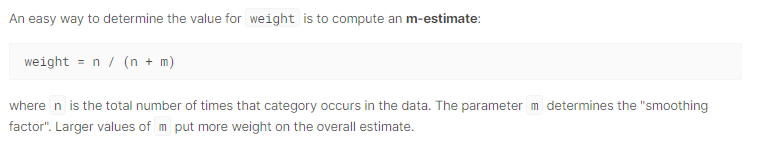

 - 여기서 m은 Smoothing factor: 값이 불안정하면 큰 M을, 값이 안정됐으면 작은 M을 선택하자!
 
### Target Encoding의 활용
 Category 범주가 많은 변수: 모두 onehotencoding하면 차원만 커지고 비효율적이기에, 이를 활용하자. 

# Exercise

In [8]:
# 3000개의 카테고리가 넘는 Zipcode --> Target Encoding으로 해결해보자
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from category_encoders import MEstimateEncoder

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')


df = pd.read_csv("./data/movielens1m.csv")
df = df.astype(np.uint8, errors='ignore') # reduce memory footprint
print("Number of Unique Zipcodes: {}".format(df["Zipcode"].nunique()))

Number of Unique Zipcodes: 3439


In [9]:
X = df.copy()
y = X.pop('Rating')

X_encode = X.sample(frac=0.25) #소수만 추출 --> 이를 실시하면 전체 데이터의 80%로만 train/valid/test가 이루어 지는 것.
y_encode = y[X_encode.index]
X_pretrain = X.drop(X_encode.index)
y_train = y[X_pretrain.index]

In [10]:
# Smoothing 실시 (Zipcode에 대해 실시)

encoder = MEstimateEncoder(cols=["Zipcode"], m=5.0)
encoder.fit(X_encode, y_encode)
X_train = encoder.transform(X_pretrain)

In [13]:
X_pretrain['Zipcode'].value_counts()

b'94110'    2797
b'60640'    2598
b'98103'    2400
b'95616'    2315
b'02138'    2298
            ... 
b'14568'      12
b'01607'      11
b'60091'      11
b'91791'      11
b'01125'      10
Name: Zipcode, Length: 3439, dtype: int64

In [11]:
X_train['Zipcode'].value_counts()

3.660307    2797
3.403716    2598
3.634005    2400
3.864643    2315
3.546708    2298
            ... 
2.556887      17
4.242516      16
3.288835      16
4.355472      15
2.994013      12
Name: Zipcode, Length: 2356, dtype: int64

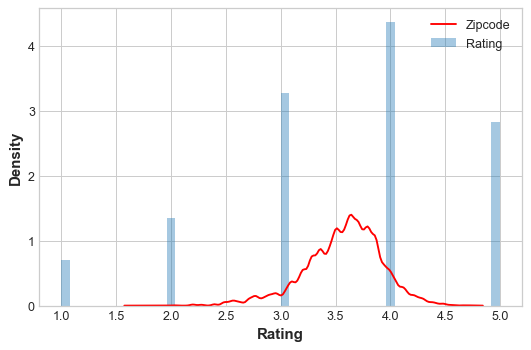

In [34]:
# target encoding 결과 실제 rating과 유사한 분포를 보이며 이는 유용하게 활용도리 수 있음을 제시!
plt.figure(dpi=90)
ax = sns.distplot(y, kde=False, norm_hist=True) #  norm_hist=True로 하여 정규화된 값을 축으로
ax = sns.kdeplot(X_train.Zipcode, color='r', ax=ax)
ax.set_xlabel("Rating")
ax.legend(labels=['Zipcode', 'Rating']);

# Exercise

In [8]:
# Setup feedback system
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from category_encoders import MEstimateEncoder
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


df = pd.read_csv("./data/ames.csv")

In [9]:
# Encoding split
X_encode = df.sample(frac=0.20, random_state=0)
y_encode = X_encode.pop("SalePrice")

# Training split
X_pretrain = df.drop(X_encode.index)
y_train = X_pretrain.pop("SalePrice")

In [10]:
# Neighborhood를 Target Encoding 실시
# Choose a set of features to encode and a value for m
encoder = MEstimateEncoder(cols=["Neighborhood"], m=5.0)


# Fit the encoder on the encoding split
encoder.fit(X_encode, y_encode)

# Encode the training split
X_train = encoder.transform(X_pretrain, y_train)

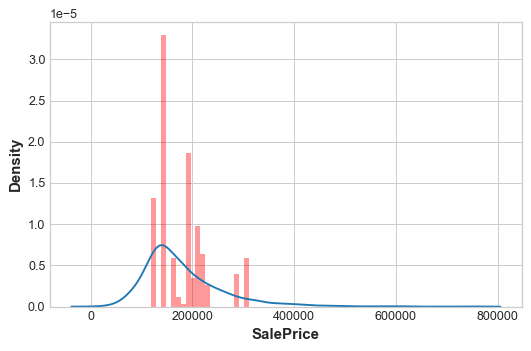

In [38]:
feature = encoder.cols

plt.figure(dpi=90)
ax = sns.distplot(y_train, kde=True, hist=False) # 꺾은선 그래프만 그리기
ax = sns.distplot(X_train[feature], color='r', ax=ax, hist=True, kde=False, norm_hist=True) # 막대기만 그리기
ax.set_xlabel("SalePrice");

In [39]:
# 성능이 향상! 데이터를 일부 희생했음에도 좋은 성능을 지닌다.
X = df.copy()
y = X.pop("SalePrice")
score_base = score_dataset(X, y)
score_new = score_dataset(X_train, y_train)

print(f"Baseline Score: {score_base:.4f} RMSLE")
print(f"Score with Encoding: {score_new:.4f} RMSLE")

Baseline Score: 0.1428 RMSLE
Score with Encoding: 0.1383 RMSLE


##### count 변수를 활용한 Target Encoding (실험)
- 결론
    1. Encoder train과 모델 train 데이터가 겹치면 안돼!!
    2. 지금 count로 하니, 결국 생성된 파생변수는 target값과 거의 일치하는 무의미한 변수가 된 것. (독립변수에 target을 넣은 것과 동일)

In [40]:
# Try experimenting with the smoothing parameter m
# Try 0, 1, 5, 50
# 거의 만점에 도달함# 거의 만점에 도달함
m = 50 # --> 50이면 전체평균이 반영되어 거의 모두 동일. 이는 지금 0만 2개고 나머지 범주는 각각 1개의 value만 가지는 경우임!

X = df.copy()
y = X.pop('SalePrice')

# Create an uninformative feature
X["Count"] = range(len(X))
X["Count"][1] = 0  # actually need one duplicate value to circumvent error-checking in MEstimateEncoder

# fit and transform on the same dataset
encoder = MEstimateEncoder(cols="Count", m=m)
X = encoder.fit_transform(X, y)

# Results
score =  score_dataset(X, y)
print(f"Score: {score:.4f} RMSLE")

Score: 0.0303 RMSLE


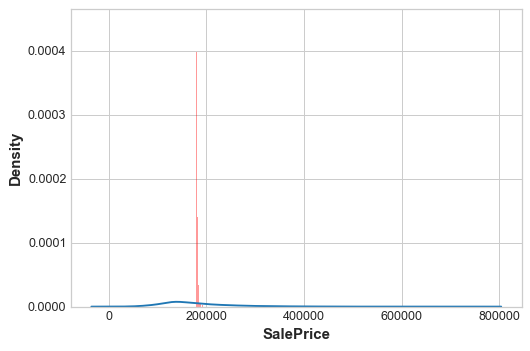

In [41]:
plt.figure(dpi=90)
ax = sns.distplot(y, kde=True, hist=False)
ax = sns.distplot(X["Count"], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice");